In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

from PIL import Image
from sklearn.model_selection import train_test_split
import time
import random
from datetime import datetime
import cv2

# Custom modules and packages
import params.learning
import uncertainty.functions
import uncertainty.evaluation
from utils import compute_mean_std
from dataset import TraversabilityDataset
import transforms
from model import ResNet18Velocity
from model2 import TraversabilityNet
from resnet50 import ResNet50
from train import train
from validate import validate
from test import test, test_models
from result import parameters_table, generate_log

## Load learning parameters

In [2]:
LEARNING_PARAMS = params.learning.LEARNING

## Prepare data

#### Compute the mean and the standard deviation of the images set

In [3]:
# If the mean and standard deviation are recomputed, you must
# overwrite the values in params.learning.NORMALIZE_PARAMS
normalize_params_compute = False

if normalize_params_compute:
    mean, std = compute_mean_std("images_train",
                                 "traversal_costs_train.csv")
    print({"rbg": {"mean": mean[:3],
                   "std": std[:3]},
           "depth": {"mean": mean[3],
                     "std": std[3]},
           "normal": {"mean": mean[4:],
                      "std": std[4:]}})

In [4]:
# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_train.csv",
    images_directory=params.learning.DATASET+"images_train",
    modes=params.learning.MODES,
    transform_image=transforms.train_transform,
    transform_depth=transforms.transform_depth,
    transform_normal=transforms.transform_normal
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_train.csv",
    images_directory=params.learning.DATASET+"images_train",
    modes=params.learning.MODES,
    transform_image=transforms.test_transform,
    transform_depth=transforms.transform_depth,
    transform_normal=transforms.transform_normal
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_test.csv",
    images_directory=params.learning.DATASET+"images_test",
    modes=params.learning.MODES,
    transform_image=transforms.test_transform,
    transform_depth=transforms.transform_depth,
    transform_normal=transforms.transform_normal
)

# Set the train dataset size
train_size = params.learning.TRAIN_SIZE/(1-params.learning.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [5]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [6]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (9079 samples)
15.0 % of the data for validation (1946 samples)
15.0 % of the data for testing (1946 samples)


## GPU?

In [7]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [8]:
# Create a model
# model = ResNet18Velocity(**params.learning.NET_PARAMS).to(device=device)
# model = TraversabilityNet(**params.learning.NET_PARAMS2).to(device=device)

model = ResNet50(10, 4).to(device=device)

In [9]:
# Create dummy tensors
images = torch.randn(32,
                     params.learning.NET_PARAMS2["img_channels"],
                     params.learning.IMAGE_SHAPE[0],
                     params.learning.IMAGE_SHAPE[1]).to(device=device)  # (batch, channels, height, width)
data = torch.randn(32, 1).to(device=device)  # (batch, features)

print(model(images, data).shape)

torch.Size([32, 10])


#### Visualize the model

In [10]:
# Open TensorBoard
# tensorboard = SummaryWriter()

# Display the architecture in TensorBoard
# images, traversal_costs, traversability_labels, linear_velocities = next(iter(train_loader))
# images = images.to(device)
# linear_velocities = linear_velocities.type(torch.float32).to(device)

# Add a dimension to the linear velocities tensor
# linear_velocities.unsqueeze_(1)

# tensorboard.add_graph(model, (images, linear_velocities))

print(model)
# print(torchsummary.summary(model, (3, 100, 100)))
# print([(name, param.shape) for name, param in model.named_parameters()])
# print(model.fc.state_dict())

ResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [16]:
# Define the loss function (combines nn.LogSoftmax() and nn.NLLLoss())
criterion_classification = nn.CrossEntropyLoss()

# Loss function to compare the expected traversal cost over the bins
# and the ground truth traversal cost
criterion_regression = nn.MSELoss()

# Load the bins midpoints
bins_midpoints = np.load(params.learning.DATASET+"bins_midpoints.npy")
bins_midpoints = torch.tensor(bins_midpoints[:, None],
                              dtype=torch.float32,
                              device=device)

# Get all the parameters excepts the weights and bias of fc layer
base_params = [param for name, param in model.named_parameters()
               if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

# Define the optimizer, with a greater learning rate for the new fc layer
# optimizer = optim.SGD([
#     {"params": base_params},
#     {"params": model.resnet18.fc.parameters(),
#      "lr": LEARNING_PARAMS["learning_rate"]*10},
# ],
#     lr=LEARNING_PARAMS["learning_rate"],
#     momentum=LEARNING_PARAMS["momentum"],
#     weight_decay=LEARNING_PARAMS["weight_decay"])

optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

# Create tensors to store the loss and accuracy values
loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])
accuracy_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])
regression_loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_loss, train_accuracy, train_regression_loss = train(model,
                                                              device,
                                                              train_loader,
                                                              optimizer,
                                                              criterion_classification,
                                                              criterion_regression,
                                                              bins_midpoints,
                                                              epoch)
    
    # Validation
    val_loss, val_accuracy, val_regression_loss = validate(model,
                                                           device,
                                                           val_loader,
                                                           criterion_classification,
                                                           criterion_regression,
                                                           bins_midpoints,
                                                           epoch) 
    
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    print("Train regression loss: ", train_regression_loss)
    print("Validation regression loss: ", val_regression_loss)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy
    # Store the computed regression losses
    regression_loss_values[0, epoch] = train_regression_loss
    regression_loss_values[1, epoch] = val_regression_loss
    
#     # Add the losses to TensorBoard
#     tensorboard.add_scalar("train_loss", train_loss, epoch)
#     tensorboard.add_scalar("val_loss", val_loss, epoch)
#     # Add the accuracies to TensorBoard
#     tensorboard.add_scalar("train_accuracy", train_accuracy, epoch)
#     tensorboard.add_scalar("val_accuracy", val_accuracy, epoch)
#     # Add the regression losses to TensorBoard
#     tensorboard.add_scalar("train_regression_loss", train_regression_loss, epoch)
#     tensorboard.add_scalar("val_regression_loss", val_regression_loss, epoch)

# # Close TensorBoard
# tensorboard.close()

  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.15111796453354
Validation accuracy:  31.757451181911613
Train regression loss:  0.8204033590958152
Validation regression loss:  0.8221166876495861


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  31.62242537724419
Validation accuracy:  31.757451181911613
Train regression loss:  0.8131125622861822
Validation regression loss:  0.85394785931853


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.23923339574843
Validation accuracy:  32.27132579650565
Train regression loss:  0.8087288316496661
Validation regression loss:  0.829273344063368


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.60270954950986
Validation accuracy:  31.551901336074
Train regression loss:  0.8032038475216274
Validation regression loss:  0.838075789271808


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.129089106729815
Validation accuracy:  31.757451181911613
Train regression loss:  0.8007808597889584
Validation regression loss:  0.8236581609874475


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.27227668245401
Validation accuracy:  31.757451181911613
Train regression loss:  0.8014438343299947
Validation regression loss:  0.8454610270554902


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.778940411939644
Validation accuracy:  31.80883864337102
Train regression loss:  0.8048807622891077
Validation regression loss:  0.8418379601885061


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.60270954950986
Validation accuracy:  31.44912641315519
Train regression loss:  0.8082253885730891
Validation regression loss:  0.8357641198596016


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.83401255644895
Validation accuracy:  29.59917780061665
Train regression loss:  0.8063167134221171
Validation regression loss:  0.8333776954744683


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.15111796453354
Validation accuracy:  32.06577595066803
Train regression loss:  0.8056134599405276
Validation regression loss:  0.8247784434771929


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.92212798766384
Validation accuracy:  31.86022610483042
Train regression loss:  0.7970777953594503
Validation regression loss:  0.8229465142625277


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.99922898997687
Validation accuracy:  31.911613566289827
Train regression loss:  0.7955296905317777
Validation regression loss:  0.8364521484883105


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.2195175680141
Validation accuracy:  30.061664953751286
Train regression loss:  0.8033633730046346
Validation regression loss:  0.845310528747371


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.043286705584315
Validation accuracy:  31.294964028776977
Train regression loss:  0.8002973701542532
Validation regression loss:  0.8287528758166266


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.646767265117305
Validation accuracy:  29.75334018499486
Train regression loss:  0.7967779472680159
Validation regression loss:  0.8446229031828584


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.503579689393106
Validation accuracy:  31.346351490236383
Train regression loss:  0.7955480237347139
Validation regression loss:  0.8294565071825122


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.34937768476704
Validation accuracy:  31.551901336074
Train regression loss:  0.8013468545297502
Validation regression loss:  0.8256009006109394


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.87807027205639
Validation accuracy:  31.500513874614594
Train regression loss:  0.8014051830264884
Validation regression loss:  0.8292853741860781


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.591695120607994
Validation accuracy:  31.911613566289827
Train regression loss:  0.793436558628586
Validation regression loss:  0.8123644187313611


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.98821456107501
Validation accuracy:  31.551901336074
Train regression loss:  0.7941534993514209
Validation regression loss:  0.8194586949758842


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.66879612292102
Validation accuracy:  32.014388489208635
Train regression loss:  0.7902464094296308
Validation regression loss:  0.8363315809945591


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.75691155413592
Validation accuracy:  31.80883864337102
Train regression loss:  0.7874516331603829
Validation regression loss:  0.8274497570561581


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.37140654257077
Validation accuracy:  31.346351490236383
Train regression loss:  0.7903015847567102
Validation regression loss:  0.8321574535526213


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.657781694019164
Validation accuracy:  32.11716341212744
Train regression loss:  0.7893022141406234
Validation regression loss:  0.8221294801743304


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.81198369864523
Validation accuracy:  31.603288797533402
Train regression loss:  0.7901375282188536
Validation regression loss:  0.8299926690390853


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.175459852406654
Validation accuracy:  31.911613566289827
Train regression loss:  0.7920350621283894
Validation regression loss:  0.8437783058549537


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.12038770789734
Validation accuracy:  31.96300102774923
Train regression loss:  0.7961752784084266
Validation regression loss:  0.8296365723258159


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.657781694019164
Validation accuracy:  31.551901336074
Train regression loss:  0.7819560944614276
Validation regression loss:  0.8359951538140656


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.13140213679921
Validation accuracy:  32.52826310380267
Train regression loss:  0.7772927326740513
Validation regression loss:  0.8224914665104913


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.494878290560635
Validation accuracy:  31.500513874614594
Train regression loss:  0.7790346239024485
Validation regression loss:  0.8319684071619002


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.35169071483644
Validation accuracy:  31.80883864337102
Train regression loss:  0.7838627258446854
Validation regression loss:  0.8559028413452086


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.18647428130851
Validation accuracy:  31.19218910585817
Train regression loss:  0.7776092417328291
Validation regression loss:  0.8365502020374673


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.95517127436943
Validation accuracy:  31.500513874614594
Train regression loss:  0.7787482134053405
Validation regression loss:  0.8495878196153485


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.83632558651834
Validation accuracy:  31.86022610483042
Train regression loss:  0.7712510727660756
Validation regression loss:  0.8490800466693815


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  32.845026985350806
Validation accuracy:  32.37410071942446
Train regression loss:  0.7793228722793956
Validation regression loss:  0.8480635969365229


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.439806146051325
Validation accuracy:  31.44912641315519
Train regression loss:  0.7755273607310275
Validation regression loss:  0.8290506992183748


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.494878290560635
Validation accuracy:  31.654676258992804
Train regression loss:  0.7711929720892033
Validation regression loss:  0.8361434902324051


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  34.03458530675184
Validation accuracy:  30.11305241521069
Train regression loss:  0.7728698691746718
Validation regression loss:  0.8285745465364612


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.72618129749972
Validation accuracy:  29.445015416238437
Train regression loss:  0.7639900259148906
Validation regression loss:  0.8615431067396383


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.23053199691596
Validation accuracy:  32.52826310380267
Train regression loss:  0.774436987831559
Validation regression loss:  0.832980284925367


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.53893600616808
Validation accuracy:  31.96300102774923
Train regression loss:  0.7695015299488122
Validation regression loss:  0.826411678165686


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.71516686859786
Validation accuracy:  32.37410071942446
Train regression loss:  0.769440169905273
Validation regression loss:  0.8147359309626407


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.53893600616808
Validation accuracy:  31.19218910585817
Train regression loss:  0.7634059868648019
Validation regression loss:  0.8739837290810757


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  34.06762859345743
Validation accuracy:  31.70606372045221
Train regression loss:  0.7678201076850085
Validation regression loss:  0.8221630918197944


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.439806146051325
Validation accuracy:  32.168550873586845
Train regression loss:  0.7573566471921725
Validation regression loss:  0.8477515524528065


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.54995043506994
Validation accuracy:  31.44912641315519
Train regression loss:  0.7647718132381708
Validation regression loss:  0.8213774307829435


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.428791717149466
Validation accuracy:  30.575539568345324
Train regression loss:  0.7626804206782664
Validation regression loss:  0.8169134317851457


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  34.475162462826304
Validation accuracy:  30.52415210688592
Train regression loss:  0.7550544259203992
Validation regression loss:  0.8445125407859927


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  33.72618129749972
Validation accuracy:  31.96300102774923
Train regression loss:  0.757319933301966
Validation regression loss:  0.8467839731544745


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  34.012556448948125
Validation accuracy:  31.96300102774923
Train regression loss:  0.7436681292216543
Validation regression loss:  0.8099222764617107


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  34.71747989866726
Validation accuracy:  31.654676258992804
Train regression loss:  0.7469536250745746
Validation regression loss:  0.8327968071718685


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  34.089657451261154
Validation accuracy:  31.500513874614594
Train regression loss:  0.7460060847896925
Validation regression loss:  0.8258255768994816


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  34.59632118074678
Validation accuracy:  30.678314491264132
Train regression loss:  0.7437165294524649
Validation regression loss:  0.8315631234254993


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  35.268201343760325
Validation accuracy:  31.140801644398767
Train regression loss:  0.7357951867538439
Validation regression loss:  0.8907370142272262


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  35.35631677497522
Validation accuracy:  31.500513874614594
Train regression loss:  0.7273164980218444
Validation regression loss:  0.8415402745614287


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  35.125013768036126
Validation accuracy:  30.472764645426516
Train regression loss:  0.7315242903333314
Validation regression loss:  0.8689078840075947


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  35.49950435069942
Validation accuracy:  31.346351490236383
Train regression loss:  0.7273164961329648
Validation regression loss:  0.8472358086070076


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  35.68674964203106
Validation accuracy:  30.678314491264132
Train regression loss:  0.7293583100635401
Validation regression loss:  0.8719360486405795


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  35.91805264897015
Validation accuracy:  30.93525179856115
Train regression loss:  0.7256316278182285
Validation regression loss:  0.8340917845241359


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  35.97312479347946
Validation accuracy:  30.421377183967113
Train regression loss:  0.7284645315417102
Validation regression loss:  0.8626679147853226


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  36.61196166978742
Validation accuracy:  28.622816032887975
Train regression loss:  0.7172066352107156
Validation regression loss:  1.0005041517195155


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  37.0745676836656
Validation accuracy:  29.18807810894142
Train regression loss:  0.7112104105697551
Validation regression loss:  0.8937451302028093


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  37.43804383742703
Validation accuracy:  31.19218910585817
Train regression loss:  0.7016024332965763
Validation regression loss:  0.8597973751240089


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  37.614274699856814
Validation accuracy:  27.697841726618705
Train regression loss:  0.6924164342418523
Validation regression loss:  1.0822727860974484


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  38.09890957153871
Validation accuracy:  29.75334018499486
Train regression loss:  0.6904059758698436
Validation regression loss:  0.8540600748335729


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  38.23108271836105
Validation accuracy:  29.34224049331963
Train regression loss:  0.6858143202016052
Validation regression loss:  0.9673982355438295


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  39.36556889525278
Validation accuracy:  27.183967112024668
Train regression loss:  0.6786851398122142
Validation regression loss:  1.0651927639226444


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  40.290780923009144
Validation accuracy:  29.75334018499486
Train regression loss:  0.6421790791964027
Validation regression loss:  0.8956761267341551


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  40.05947791607005
Validation accuracy:  30.318602261048305
Train regression loss:  0.6414596447852295
Validation regression loss:  0.88812811941397


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  40.65425707677057
Validation accuracy:  28.16032887975334
Train regression loss:  0.6446646296642196
Validation regression loss:  0.9313420878082025


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  42.22932040973676
Validation accuracy:  29.496402877697843
Train regression loss:  0.6354773561929313
Validation regression loss:  0.8881814968390543


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  43.165546866394976
Validation accuracy:  29.547790339157245
Train regression loss:  0.6115213065395053
Validation regression loss:  0.9130792901164195


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  43.99162903403459
Validation accuracy:  29.75334018499486
Train regression loss:  0.6038621344511778
Validation regression loss:  0.9448924323574441


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  45.23625949994493
Validation accuracy:  28.9311408016444
Train regression loss:  0.5907283344004356
Validation regression loss:  0.9144148826599121


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  45.26930278665051
Validation accuracy:  27.90339157245632
Train regression loss:  0.6029802700373489
Validation regression loss:  1.0634479625303237


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  46.08437052538826
Validation accuracy:  26.927029804727646
Train regression loss:  0.5695570981733395
Validation regression loss:  1.0829933529994527


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  48.11102544333076
Validation accuracy:  26.56731757451182
Train regression loss:  0.5557254718642839
Validation regression loss:  1.2842044107249526


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  49.39971362484855
Validation accuracy:  28.82836587872559
Train regression loss:  0.5348736444409464
Validation regression loss:  0.9868287585797857


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  50.9857913867166
Validation accuracy:  29.290853031860227
Train regression loss:  0.5194625362334117
Validation regression loss:  0.9547088253693502


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  52.6709990087014
Validation accuracy:  28.41726618705036
Train regression loss:  0.5125294395945441
Validation regression loss:  1.005522186638879


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  53.893600616808016
Validation accuracy:  30.88386433710175
Train regression loss:  0.4982985364351894
Validation regression loss:  0.8989082770269425


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  55.51272166538165
Validation accuracy:  25.179856115107913
Train regression loss:  0.46643450297415257
Validation regression loss:  1.2108729501239588


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  56.65822227117524
Validation accuracy:  28.725590955806783
Train regression loss:  0.467866326590449
Validation regression loss:  0.9485799929157632


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  57.33010243418879
Validation accuracy:  29.907502569373072
Train regression loss:  0.46604218837660805
Validation regression loss:  0.9642575270816928


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  58.6408194735103
Validation accuracy:  26.927029804727646
Train regression loss:  0.44117617898318967
Validation regression loss:  1.051517204183047


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  60.821676396078864
Validation accuracy:  27.183967112024668
Train regression loss:  0.44261431518260025
Validation regression loss:  1.0892200372258172


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  62.56195616257297
Validation accuracy:  23.381294964028775
Train regression loss:  0.3920973968023146
Validation regression loss:  1.622011088934101


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  63.751514483974006
Validation accuracy:  25.28263103802672
Train regression loss:  0.40640448860194484
Validation regression loss:  1.263210576088702


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  65.69005397070161
Validation accuracy:  29.033915724563208
Train regression loss:  0.40316871524801556
Validation regression loss:  0.9666129731741108


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  65.89932811983698
Validation accuracy:  25.025693730729703
Train regression loss:  0.3987425807338785
Validation regression loss:  1.2149523887477938


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  68.45467562506884
Validation accuracy:  24.820143884892087
Train regression loss:  0.3823113055558692
Validation regression loss:  1.2689520648268402


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  68.67496420310607
Validation accuracy:  27.646454265159303
Train regression loss:  0.3828722023418252
Validation regression loss:  1.0719282700390111


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  70.0627822447406
Validation accuracy:  28.674203494347378
Train regression loss:  0.3732985285648578
Validation regression loss:  1.0503942336215348


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  71.50567243088446
Validation accuracy:  29.958890030832478
Train regression loss:  0.35082326005672065
Validation regression loss:  0.9927580542251712


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  72.9816059037339
Validation accuracy:  26.56731757451182
Train regression loss:  0.3508412013171424
Validation regression loss:  1.0800552133653984


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  74.28130851415354
Validation accuracy:  26.72147995889003
Train regression loss:  0.3580705731005316
Validation regression loss:  1.1031229808682301


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  76.03260270954951
Validation accuracy:  23.895169578622816
Train regression loss:  0.31879836163470443
Validation regression loss:  1.5056149949792956


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  77.3763630355766
Validation accuracy:  25.847893114080165
Train regression loss:  0.31053623941425285
Validation regression loss:  1.12459808783453


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  77.33230531996917
Validation accuracy:  27.595066803699897
Train regression loss:  0.3044124024224953
Validation regression loss:  1.0005400288300437


  0%|          | 0/284 [00:00<?, ?batch/s]

  0%|          | 0/61 [00:00<?, ?batch/s]

Train accuracy:  79.31490252230422
Validation accuracy:  26.515930113052416
Train regression loss:  0.307277540453303
Validation regression loss:  1.1077591405540217


### Visualization

Text(0.5, 0, 'Epoch')

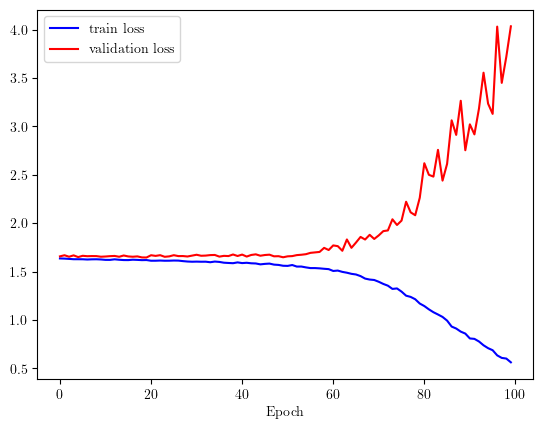

In [17]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

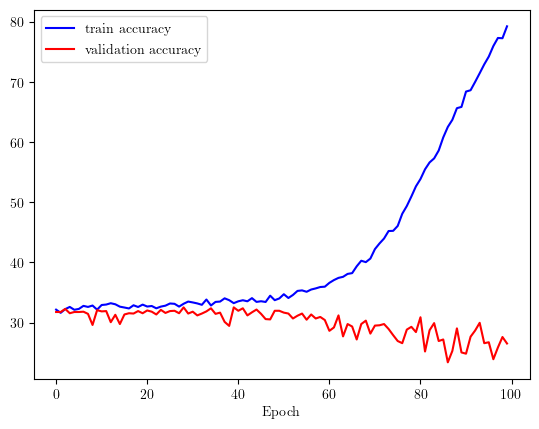

In [18]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

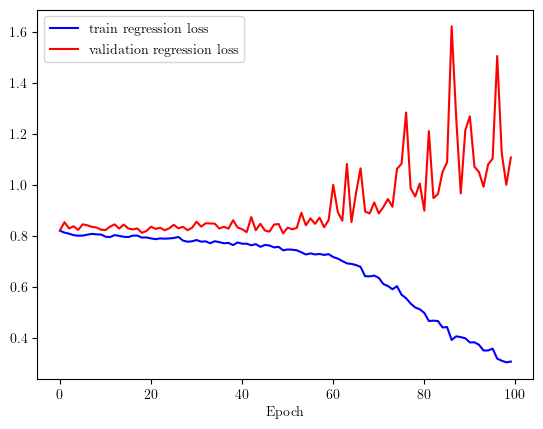

In [19]:
# Regression loss
train_regression_losses = regression_loss_values[0]
val_regression_losses = regression_loss_values[1]

plt.plot(train_regression_losses, "b", label="train regression loss")
plt.plot(val_regression_losses, "r", label="validation regression loss")

plt.legend()
plt.xlabel("Epoch")

## Testing

#### Testing the model

In [15]:
# Set the uncertainty function
uncertainty_function = uncertainty.functions.shannon_entropy

# Test the model
_,\
test_accuracy,\
test_regression_loss,\
test_regression_losses,\
uncertainties = test(model,
                     device,
                     test_loader,
                     criterion_classification,
                     criterion_regression,
                     bins_midpoints,
                     uncertainty_function)

print("Test accuracy: ", test_accuracy)
print("Regression loss: ", test_regression_loss)

Test accuracy:  31.911613566289827
Regression loss:  0.7975611364255186


## Save model parameters

In [16]:
# Save the model parameters
# torch.save(model.state_dict(), "multimodal_velocity.params")

## Assessing the relevance of the uncertainty

In [17]:
# Compute the test losses after successive removal of the samples
# with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty =\
    uncertainty.evaluation.uncertainty_relevance(
        model,
        device,
        criterion_classification,
        criterion_regression,
        bins_midpoints,
        uncertainty_function,
        test,
        test_set,
        test_regression_loss,
        test_regression_losses,
        uncertainties)

#### Plotting the results

Text(0, 0.5, 'Regression error (MSE)')

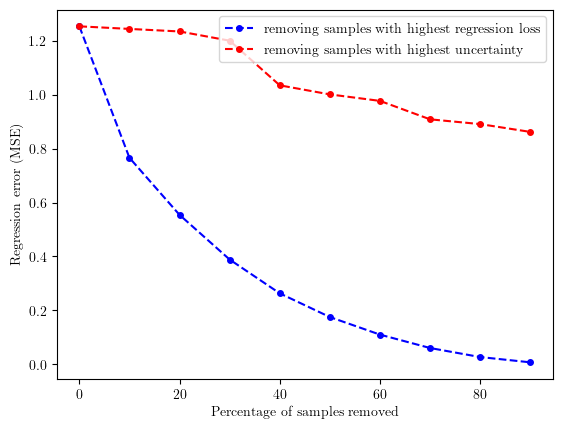

In [18]:
plt.plot(range(0, 100, 10),
         test_losses_loss,
         "bo--",
         label="removing samples with highest regression loss",
         markersize=4)
plt.plot(range(0, 100, 10),
         test_losses_uncertainty,
         "ro--",
         label="removing samples with highest uncertainty",
         markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")

## Generate a log directory

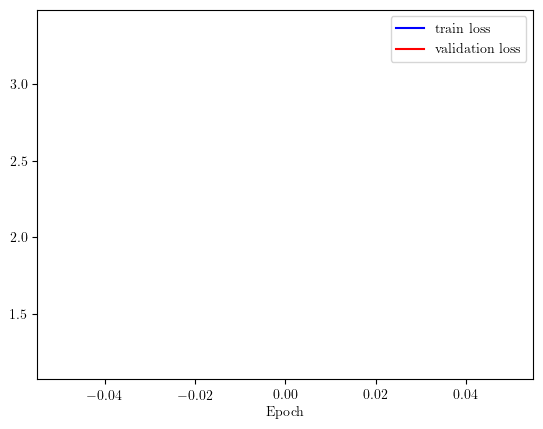

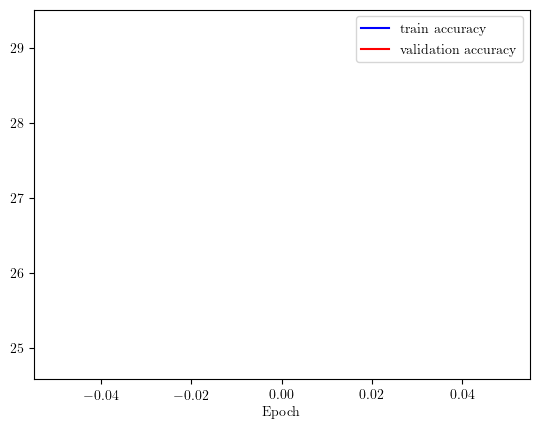

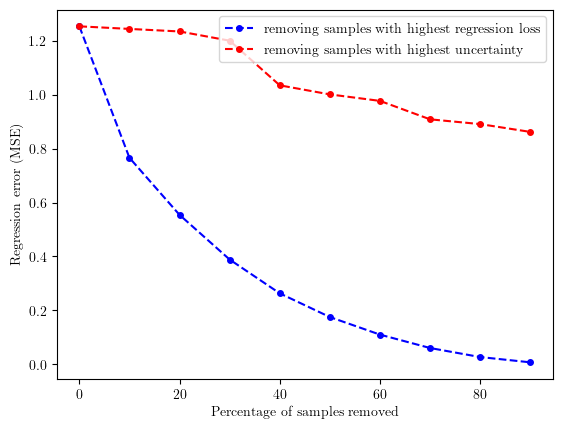

In [19]:
# Get the learning parameters table
params_table = parameters_table(dataset=params.learning.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.learning.LOG_DIR:
    results_directory = "logs/_" +\
                        params.learning.LOG_DIR
else:
    results_directory = "logs/_" +\
                        datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
                        
# Generate the log directory
generate_log(results_directory=results_directory,
             test_regression_loss=test_regression_loss,
             test_accuracy=test_accuracy,
             parameters_table=params_table,
             model=model,
             regression_loss_values=regression_loss_values,
             accuracy_values=accuracy_values,
             test_losses_loss=test_losses_loss,
             test_losses_uncertainty=test_losses_uncertainty)

### Ensemble learning

#### Training the models

In [ ]:
# Create a list of models
nb_models = 3
some_models = [ResNet18Velocity().to(device=device) for _ in range(nb_models)]

# Loop over the models
for i in range(nb_models):
    
    print(f"Training model {i+1}/{nb_models}")
    
    # Get all the parameters excepts the weights and bias of fc layer
    base_params = [param for name, param in some_models[i].named_parameters()
                   if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

    # Define the optimizer, with a greater learning rate for the new fc layer
    optimizer = optim.SGD([
        {"params": base_params},
        {"params": some_models[i].resnet18.fc.parameters(),
         "lr": LEARNING_PARAMS["learning_rate"] * 10},
    ],
        lr=LEARNING_PARAMS["learning_rate"],
        momentum=LEARNING_PARAMS["momentum"],
        weight_decay=LEARNING_PARAMS["weight_decay"])
    
    # Loop over the epochs
    for epoch in range(LEARNING_PARAMS["nb_epochs"]):

        # Train the model
        train_loss, train_accuracy, train_regression_loss = train(some_models[i],
                                                                  device,
                                                                  train_loader,
                                                                  optimizer,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  epoch)

Training model 1/3


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/354 [00:00<?, ?batch/s]

Training model 2/3


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/354 [00:00<?, ?batch/s]

Training model 3/3


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/354 [00:00<?, ?batch/s]

In [ ]:
# Create arrays to store the test losses
# test_losses_loss = np.zeros((nb_models, 10))
# test_losses_uncertainty = np.zeros((nb_models, 10))

uncertainty_function = uncertainty.functions.shannon_entropy

# Test the models
test_regression_loss, test_regression_losses, uncertainties = test_models(some_models,
                                                                          device,
                                                                          test_loader,
                                                                          criterion_classification,
                                                                          criterion_regression,
                                                                          bins_midpoints,
                                                                          uncertainty_function)
print("Test regression loss: ", test_regression_loss)

# Compute the test losses after successive removal of the samples with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty = \
    uncertainty.evaluation.uncertainty_relevance_models(some_models,
                                                        device,
                                                        criterion_classification,
                                                        criterion_regression,
                                                        bins_midpoints,
                                                        uncertainty_function,
                                                        test_models,
                                                        test_set,
                                                        test_regression_loss,
                                                        test_regression_losses,
                                                        uncertainties)

Test regression loss:  0.8872574639585614


#### Plotting the results

Text(0, 0.5, 'Regression error (MSE)')

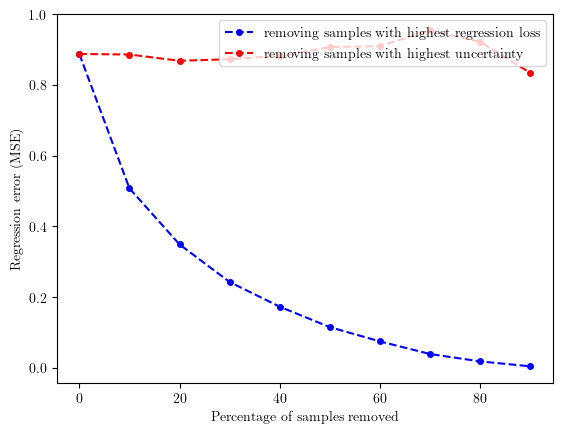

In [ ]:
plt.plot(range(0, 100, 10),
         test_losses_loss,
         "bo--",
         label="removing samples with highest regression loss",
         markersize=4)
plt.plot(range(0, 100, 10),
         test_losses_uncertainty,
         "ro--",
         label="removing samples with highest uncertainty",
         markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")